# Import Library

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support

import joblib
import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")

# Load Data

In [27]:
df = pd.read_csv('data/Loan_approval_data_2025.csv')

print("Info dataset:")
print(df.info())
print("\nBeberapa baris pertama:")
print(df.head())

print("\nJumlah nilai null:")
print(df.isnull().sum())

Info dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_id              50000 non-null  object 
 1   age                      50000 non-null  int64  
 2   occupation_status        50000 non-null  object 
 3   years_employed           50000 non-null  float64
 4   annual_income            50000 non-null  int64  
 5   credit_score             50000 non-null  int64  
 6   credit_history_years     50000 non-null  float64
 7   savings_assets           50000 non-null  int64  
 8   current_debt             50000 non-null  int64  
 9   defaults_on_file         50000 non-null  int64  
 10  delinquencies_last_2yrs  50000 non-null  int64  
 11  derogatory_marks         50000 non-null  int64  
 12  product_type             50000 non-null  object 
 13  loan_intent              50000 non-null  object 
 14  loan_amo

# Data Cleaning

In [28]:
# Tangani missing values (isi median untuk numerik, modus untuk kategorikal)
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].median(), inplace=True)

# Pastikan target 'loan_status' dalam format biner
if df['loan_status'].dtype == 'object':
    df['loan_status'] = df['loan_status'].map({'Approved': 1, 'Rejected': 0})

# Cek duplikat
df.drop_duplicates(inplace=True)

# Exploratory Data Analysis (EDA)

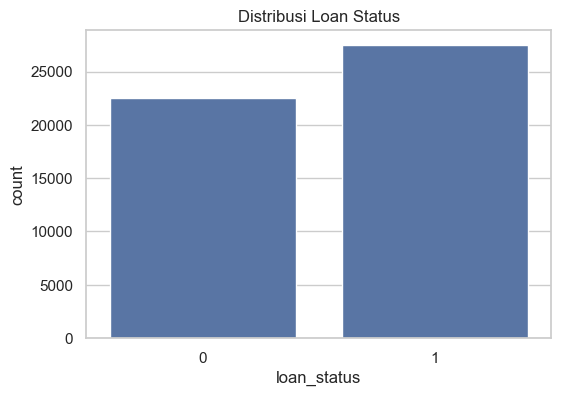

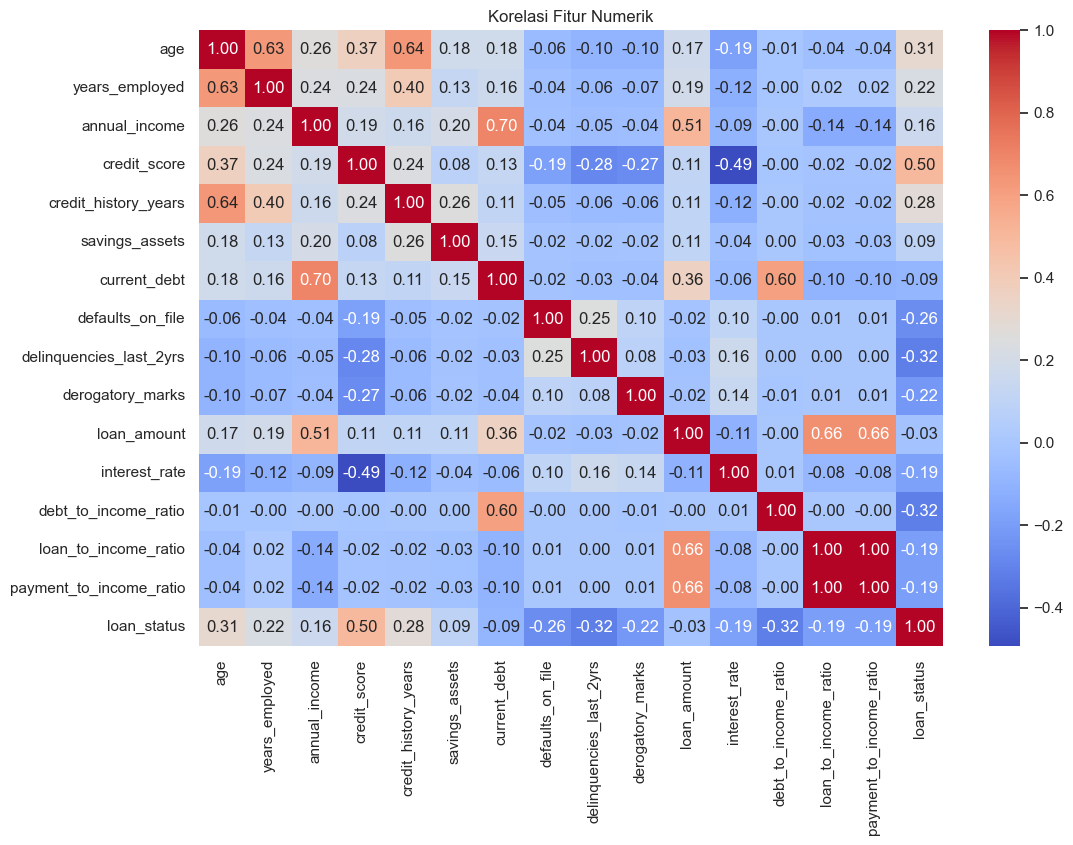

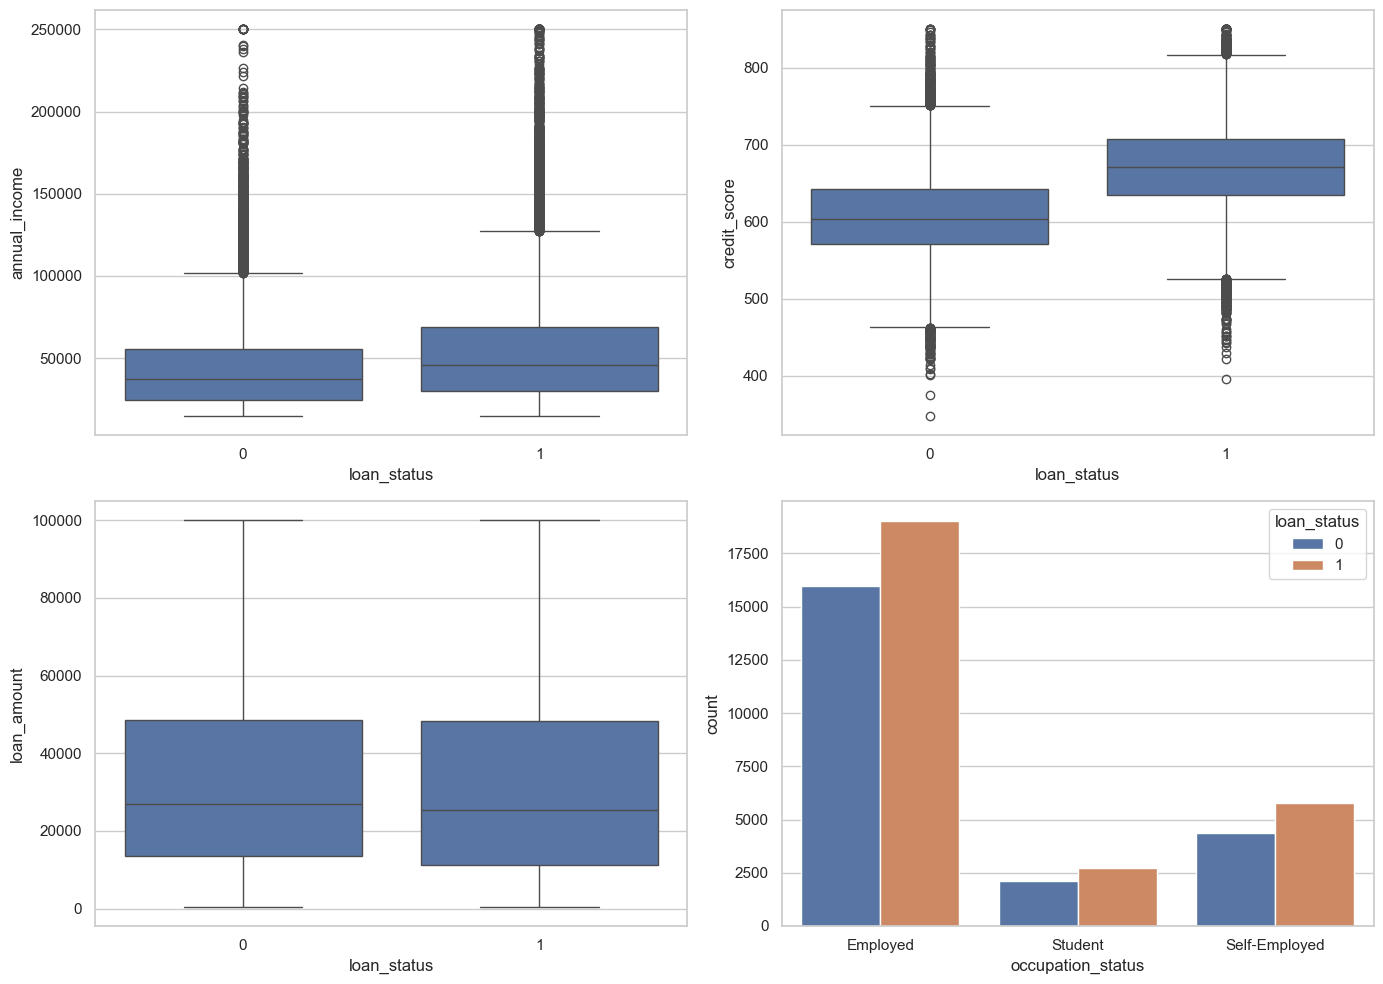

In [29]:
# Distribusi target
plt.figure(figsize=(6,4))
sns.countplot(x='loan_status', data=df)
plt.title('Distribusi Loan Status')
plt.show()

# Korelasi fitur numerik
numeric_cols = df.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(12,8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Korelasi Fitur Numerik')
plt.show()

# Distribusi beberapa fitur penting berdasarkan loan_status
fig, axes = plt.subplots(2, 2, figsize=(14,10))
sns.boxplot(x='loan_status', y='annual_income', data=df, ax=axes[0,0])
sns.boxplot(x='loan_status', y='credit_score', data=df, ax=axes[0,1])
sns.boxplot(x='loan_status', y='loan_amount', data=df, ax=axes[1,0])
sns.countplot(x='occupation_status', hue='loan_status', data=df, ax=axes[1,1])
plt.tight_layout()
plt.show()

# Preprocessing

In [30]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

# Encoding fitur kategorikal
label_encoders = {}
for col in X.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le  # Simpan encoder jika perlu untuk inferensi nanti

# Scaling fitur numerik
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Train Model

In [31]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(random_state=42, n_jobs=-1)
}

In [32]:
results = {}
for name, model in models.items():
    # Cross-validation dengan F1-score (untuk kelas 0)
    cv_f1_0 = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_macro')  # atau 'f1_weighted'
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Hitung metrik per kelas
    precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average=None)
    
    results[name] = {
        'CV F1 Macro': cv_f1_0.mean(),
        'Test Accuracy': accuracy_score(y_test, y_pred),
        'Precision (Rejected)': precision[0],   # kelas 0
        'Recall (Rejected)': recall[0],         # kelas 0
        'F1 (Rejected)': f1[0],                 # kelas 0
        'Precision (Approved)': precision[1],   # kelas 1
        'Recall (Approved)': recall[1],         # kelas 1
        'F1 (Approved)': f1[1],                 # kelas 1
        'Model': model
    }
    
    print(f"\n{name}:")
    print(f"CV F1 Macro: {cv_f1_0.mean():.4f} (+/- {cv_f1_0.std()*2:.4f})")
    print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision (Rejected): {precision[0]:.4f}")
    print(f"Recall (Rejected): {recall[0]:.4f}")
    print(f"F1 (Rejected): {f1[0]:.4f}")


Logistic Regression:
CV F1 Macro: 0.8430 (+/- 0.0035)
Test Accuracy: 0.8410
Precision (Rejected): 0.8351
Recall (Rejected): 0.8053
F1 (Rejected): 0.8199

Random Forest:
CV F1 Macro: 0.9069 (+/- 0.0045)
Test Accuracy: 0.9100
Precision (Rejected): 0.9057
Recall (Rejected): 0.8928
F1 (Rejected): 0.8992

XGBoost:
CV F1 Macro: 0.9258 (+/- 0.0054)
Test Accuracy: 0.9233
Precision (Rejected): 0.9233
Recall (Rejected): 0.9046
F1 (Rejected): 0.9138



🟢 Model Terbaik: XGBoost

Classification Report:
              precision    recall  f1-score   support

    Rejected       0.92      0.90      0.91      4495
    Approved       0.92      0.94      0.93      5505

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



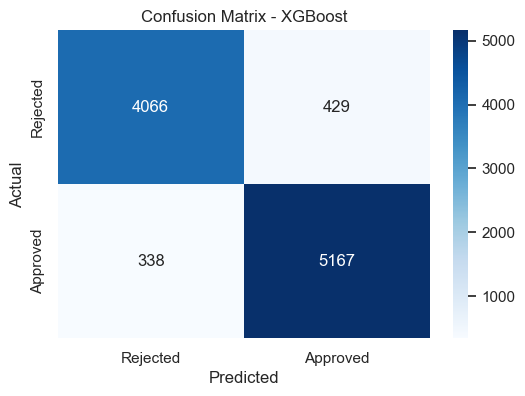

In [33]:
best_model_name = max(results, key=lambda k: results[k]['F1 (Rejected)'])
best_model = results[best_model_name]['Model']

print(f"\n🟢 Model Terbaik: {best_model_name}")
print("\nClassification Report:")
print(classification_report(y_test, best_model.predict(X_test), target_names=['Rejected', 'Approved']))

cm = confusion_matrix(y_test, best_model.predict(X_test))
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Rejected', 'Approved'],
            yticklabels=['Rejected', 'Approved'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

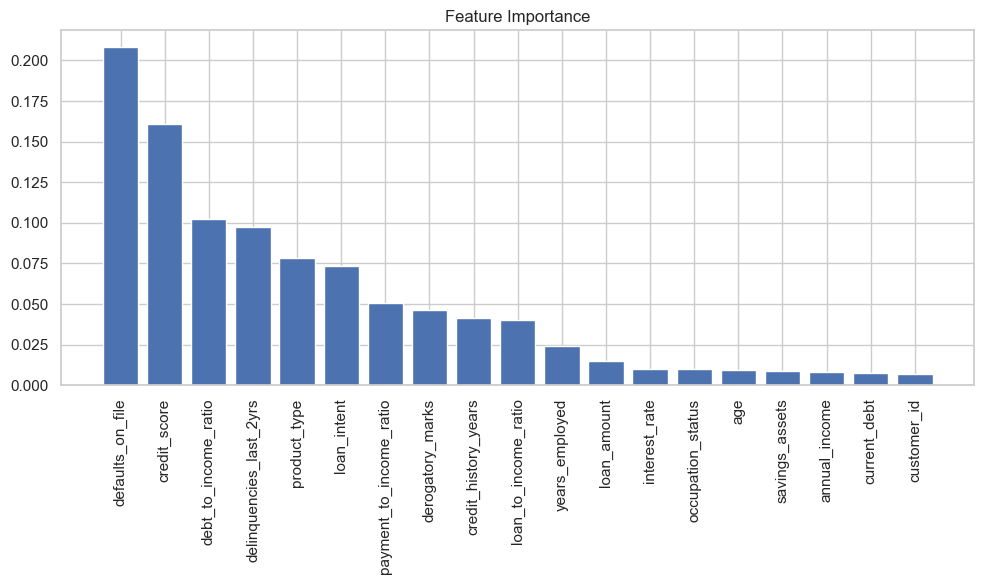

In [34]:
# Contoh dengan XGBoost
import matplotlib.pyplot as plt

feat_importance = best_model.feature_importances_
features = X_train.columns

plt.figure(figsize=(10,6))
indices = np.argsort(feat_importance)[::-1]
plt.bar(range(len(features)), feat_importance[indices], align='center')
plt.xticks(range(len(features)), [features[i] for i in indices], rotation=90)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

# Feature Selection by Importance

In [37]:
# Ambil feature importance dari XGBoost (gunakan best_model yang sudah ada)
feat_importance = best_model.feature_importances_
features = X_train.columns

# Buat mask untuk fitur penting (importance >= 0.01)
important_mask = feat_importance >= 0.01
important_features = features[important_mask]

print(f"\n📌 Fitur Penting ({len(important_features)} dari {len(features)}):")
print(list(important_features))

# Buat dataset baru dengan fitur penting saja
X_train_reduced = X_train[important_features]
X_test_reduced = X_test[important_features]

# Latih ulang model dengan fitur terpilih
model_reduced = XGBClassifier(random_state=42, n_jobs=-1)
model_reduced.fit(X_train_reduced, y_train)

# Evaluasi ulang
y_pred_reduced = model_reduced.predict(X_test_reduced)
precision_red, recall_red, f1_red, _ = precision_recall_fscore_support(y_test, y_pred_reduced, average=None)

# Simpan hasil evaluasi
results['XGBoost (Reduced)'] = {
    'CV F1 Macro': cross_val_score(model_reduced, X_train_reduced, y_train, cv=5, scoring='f1_macro').mean(),
    'Test Accuracy': accuracy_score(y_test, y_pred_reduced),
    'Precision (Rejected)': precision_red[0],
    'Recall (Rejected)': recall_red[0],
    'F1 (Rejected)': f1_red[0],
    'Model': model_reduced,
    'All Features': False,
    'Selected Features': list(important_features)
}

print(f"\n📊 Hasil Setelah Seleksi Fitur:")
print(f"CV F1 Macro: {results['XGBoost (Reduced)']['CV F1 Macro']:.4f}")
print(f"Test Accuracy: {results['XGBoost (Reduced)']['Test Accuracy']:.4f}")
print(f"F1 (Rejected): {results['XGBoost (Reduced)']['F1 (Rejected)']:.4f}")
print(f"Jumlah Fitur: {len(important_features)}")


📌 Fitur Penting (14 dari 19):
['occupation_status', 'years_employed', 'credit_score', 'credit_history_years', 'defaults_on_file', 'delinquencies_last_2yrs', 'derogatory_marks', 'product_type', 'loan_intent', 'loan_amount', 'interest_rate', 'debt_to_income_ratio', 'loan_to_income_ratio', 'payment_to_income_ratio']

📊 Hasil Setelah Seleksi Fitur:
CV F1 Macro: 0.9251
Test Accuracy: 0.9259
F1 (Rejected): 0.9167
Jumlah Fitur: 14


# Compare Model Perform

In [38]:
print("\n" + "="*60)
print("🔍 PERBANDINGAN MODEL SEBELUM & SESUDAH SELEKSI FITUR")
print("="*60)

print(f"{'Model':<25} {'F1 (Rejected)':<15} {'Accuracy':<10} {'Fitur'}")
print("-"*60)

for name, res in results.items():
    if 'Reduced' in name:
        color = "\033[92m"  # Hijau
    else:
        color = "\033[93m"  # Kuning
    reset = "\033[0m"
    print(f"{color}{name:<25}{res['F1 (Rejected)']:<15.4f}{res['Test Accuracy']:<10.4f}{len(res.get('Selected Features', features)) if 'Selected Features' in res else len(features)}{reset}")


🔍 PERBANDINGAN MODEL SEBELUM & SESUDAH SELEKSI FITUR
Model                     F1 (Rejected)   Accuracy   Fitur
------------------------------------------------------------
Logistic Regression      0.8199         0.8410    19
Random Forest            0.8992         0.9100    19
XGBoost                  0.9138         0.9233    19
XGBoost (Reduced)        0.9167         0.9259    14


# Export Model & Preprocessor

In [39]:
# Simpan model akhir (reduced)
joblib.dump(model_reduced, 'best_loan_approval_model_reduced.pkl')

# Simpan scaler dan encoder
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')

# Simpan daftar fitur penting (untuk referensi di produksi)
with open('selected_features.txt', 'w') as f:
    for feat in important_features:
        f.write(feat + '\n')

print(f"\n✅ Model akhir (dengan {len(important_features)} fitur) berhasil disimpan!")
print("📁 File yang dihasilkan:")
print("   - best_loan_approval_model_reduced.pkl")
print("   - scaler.pkl")
print("   - label_encoders.pkl")
print("   - selected_features.txt")


✅ Model akhir (dengan 14 fitur) berhasil disimpan!
📁 File yang dihasilkan:
   - best_loan_approval_model_reduced.pkl
   - scaler.pkl
   - label_encoders.pkl
   - selected_features.txt
